# A complete workflow of visual search


# Solving the problem with Neural Search

[Neural search](https://docs.jina.ai/get-started/neural-search/) leverages state-of-the-art AI to build every component of a search system. Thanks to recent advances in deep neural networks, a neural search system can go way beyond simple text search. It enables advanced intelligence on all kinds of unstructured data, such as images, audio, video, PDF, 3D mesh, you name it.

## The neural search framework: Jina

[Jina](https://github.com/jina-ai/jina/) is a neural search framework that empowers anyone to build state-of-the-art and scalable deep learning search applications in minutes.

## Jina basic concepts:

- **[Document](https://docs.jina.ai/fundamentals/document/)** is the basic data type in Jina;
- **[Executor](https://docs.jina.ai/fundamentals/executor/)** is how Jina processes Documents;
- **[Flow](https://docs.jina.ai/fundamentals/flow/)** is how Jina streamlines and scales Executors.

# Document

Here we prepare the data we want to search.

Jina provides two abstractions for data.

- `Document`
- `DocumentArray`

A Document can be text, image, audio, video, or any other kind of data that a neural network can process. It could even be 3D meshes or amino acids!

workspace = './workspace'
os.environ['JINA_WORKSPACE'] = workspace
os.environ['JINA_PORT'] = os.environ.get('JINA_PORT', str(45678))

if os.path.exists(workspace):
    print(f'Workspace at {workspace} exists. Will delete')
    rmtree(workspace)

### Load images into Document Array

In [17]:
from docarray import DocumentArray, Document
import torchvision

# Convert to tensor, normalize so they're all similar enough
def preproc(d: Document):
    return (d.load_uri_to_image_tensor()  # load
             .set_image_tensor_shape((80, 60))  # ensure all images right size (dataset image size _should_ be (80, 60))
             .set_image_tensor_normalization()  # normalize color 
             .set_image_tensor_channel_axis(-1, 0))  # switch color axis for the PyTorch model later

indexing_documents = DocumentArray.from_files("./flag_imgs/*.jpg", size=10000)
indexing_documents.apply(preproc)
model = torchvision.models.resnet50(pretrained=True)  # load ResNet50

indexing_documents.embed(model, device="cpu")

                             Documents Summary                              
                                                                            
  Length                 196                                                
  Homogenous Documents   True                                               
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri', 'embedding')  
                                                                            
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  embedding   ('Tensor',)    196              False            
  id          ('str',)       196              False            
  mime_type   ('str',)       1                False            
  tensor      ('str',)       196              False            
  uri         ('ndarray',)   196              False            
                                                               
          Storage Summary          
                                   
  Class     DocumentArrayInMemory  
  Backend   In Memory

### Initialize

In [18]:
# construct left/right document arrays
right_da = indexing_documents
left_da = DocumentArray([indexing_documents[0]]) # change THIS index!

# match document arrays by use of embedding (feature vector similarity)
left_da.match(right_da, limit=9)

# show cosine distance of top 9 from query
for d in left_da:
    for m in d.matches:
        print(d.uri, m.uri, m.scores['cosine'].value)    

./flag_imgs/france_6.jpg ./flag_imgs/france_6.jpg -3.5762787e-07
./flag_imgs/france_6.jpg ./flag_imgs/france_12.jpg 0.16099036
./flag_imgs/france_6.jpg ./flag_imgs/russia_4.jpg 0.17679733
./flag_imgs/france_6.jpg ./flag_imgs/canada_4.jpg 0.19021356
./flag_imgs/france_6.jpg ./flag_imgs/russia_1.jpg 0.20139658
./flag_imgs/france_6.jpg ./flag_imgs/russia_12.jpg 0.2192083
./flag_imgs/france_6.jpg ./flag_imgs/france_1.jpg 0.22045231
./flag_imgs/france_6.jpg ./flag_imgs/usa_13.jpg 0.25158602
./flag_imgs/france_6.jpg ./flag_imgs/germany_3.jpg 0.25528848


### Display query image

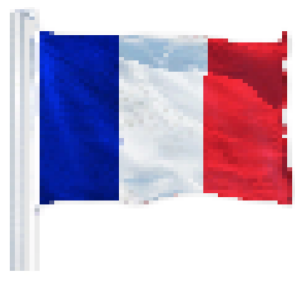

In [19]:
(DocumentArray(left_da[0], copy=True) # dont change this index!
    .apply(lambda d: d.set_image_tensor_channel_axis(0, -1)
                      .set_image_tensor_inv_normalization())
    .plot_image_sprites())

### Display top 9 matches

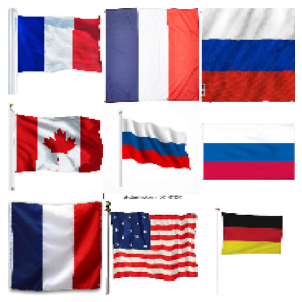

In [20]:
(DocumentArray(left_da[0].matches, copy=True) # dont change this index!
    .apply(lambda d: d.set_image_tensor_channel_axis(0, -1)
                      .set_image_tensor_inv_normalization())
    .plot_image_sprites())

In [21]:
print(left_da[0].uri)

./flag_imgs/france_6.jpg


### [INFO] below metrics are wrong. need to debug.

In [22]:
groundtruth = DocumentArray(
    Document(uri=d.uri, matches=[Document(uri=d.uri.replace('left', 'right'))]) for d in left_da)

In [23]:
for k in range(1, 6):
    print(f'recall@{k}',
          left_da.evaluate(
            groundtruth,
            hash_fn=lambda d: d.uri,
            metric='recall_at_k',
            k=k,
            max_rel=1))

recall@1 1.0
recall@2 1.0
recall@3 1.0
recall@4 1.0
recall@5 1.0


In [24]:
print(left_da)
for l in left_da:
    print(l)
    print(l.mime_type)
    print(l.matches)

<DocumentArray (length=1) at 140457992577520>
<Document ('id', 'tensor', 'mime_type', 'uri', 'embedding', 'evaluations', 'matches') at 0865aa66952111ec96f7219d3e7e025a>
image/jpeg
<DocumentArray (length=9) at 140457992783904>
